In [1]:
!pip3 install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip3 install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/"

Mounted at /content/drive
/content/drive/My Drive


In [6]:
import os
os.chdir("/CIFAR-10_Object_Recognition/")

# Data Loading  

In [7]:
# pytorch
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# other
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

In [8]:
batch_size=200
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [9]:
trainset = datasets.CIFAR10(root='dataset/',train=True,
                                        download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = datasets.CIFAR10(root='dataset/',train=False,
                                       download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
test = iter(trainloader)
images, labels = next(test)

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

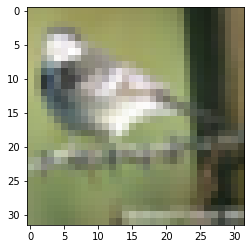

bird


In [12]:
# imshow(torchvision.utils.make_grid(images))
num = 1
imshow(images[num])
print(classes[labels[num]])

# Model  

In [50]:
resnet_pt = models.resnet18(pretrained=True)
for param in resnet_pt.parameters():
    param.requires_grad = False
for param in resnet_pt.layer4[1].parameters():
    param.requires_grad = True
fc_in_features = resnet_pt.fc.in_features

resnet_pt.fc = nn.Linear(fc_in_features, len(classes))
resnet_pt = resnet_pt.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
summary(resnet_pt, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [49]:
print(resnet_pt)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_pt.parameters(), lr=0.001,
                      momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [16]:
# Training
def train(epoch, model, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = train_loss/total
    epoch_acc = correct/total*100
    print("Train | Loss:%.4f Acc: %.2f%% (%s/%s)" 
        % (epoch_loss, epoch_acc, correct, total))
    return epoch_loss, epoch_acc

In [17]:
def test(epoch, model, criterion, optimizer):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()*inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = test_loss/total
        epoch_acc = correct/total*100
        print("Test | Loss:%.4f Acc: %.2f%% (%s/%s)" 
            % (epoch_loss, epoch_acc, correct, total))
    return epoch_loss, epoch_acc

In [ ]:
start_time = time.time()
best_acc = 0
epoch_length = 100
save_loss = {"train":[],
             "test":[]}
save_acc = {"train":[],
             "test":[]}
for epoch in range(epoch_length):
    print("Epoch %s" % epoch)
    train_loss, train_acc = train(epoch, resnet_pt, criterion, optimizer)
    save_loss['train'].append(train_loss)
    save_acc['train'].append(train_acc)

    test_loss, test_acc = test(epoch, resnet_pt, criterion, optimizer)
    save_loss['test'].append(test_loss)
    save_acc['test'].append(test_acc)

    scheduler.step()

    # Save model
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(resnet_pt.state_dict())
    resnet_pt.load_state_dict(best_model_wts)

learning_time = time.time() - start_time
print(f'**Learning time: {learning_time // 60:.0f}m {learning_time % 60:.0f}s')

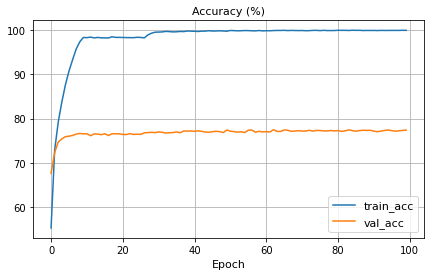

In [ ]:
plt.figure(figsize=(7,4))
plt.title("Accuracy (%)", fontsize=11)
plt.plot(range(epoch_length),save_acc["train"], label="train_acc")
plt.plot(range(epoch_length),save_acc["test"], label="val_acc")
plt.grid()
plt.xlabel("Epoch", fontsize=11)
# plt.ylim([50,60])
plt.legend(fontsize=11)
plt.savefig("freeze_none.png")
plt.show()

## **Learning time: 21m 20s : last layer만 학습

In [ ]:
import pandas as pd
df = pd.DataFrame()
df["train_acc"] = save_acc["train"]
df["test_acc"] = save_acc["test"]
df["train_loss"] = save_loss["train"]
df["test_loss"] = save_loss["test"]
df.to_csv("freeze_none.csv", index=False)

In [42]:
import pandas as pd
df = pd.read_csv("freeze_some.csv")

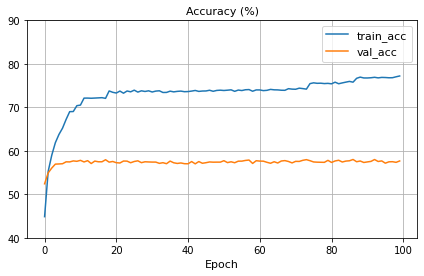

In [46]:
plt.figure(figsize=(7,4))
plt.title("Accuracy (%)", fontsize=11)
plt.plot(range(100),df["train_acc"], label="train_acc")
plt.plot(range(100),df["test_acc"], label="val_acc")
plt.grid()
plt.xlabel("Epoch", fontsize=11)
plt.ylim([40,90])
plt.legend(fontsize=11)
plt.savefig("freeze_none.png")
plt.show()